# Compiling Deepchem Torch Models

Deep Learning models typically involve millions or even billions of parameters (as in the case of LLMs) that need to be fine-tuned through an iterative training processes. During training, these models process vast amounts of data  to learn patterns and features effectively. This data-intensive nature, combined with the computational complexity of operations like matrix multiplications and backpropagation, leads to lengthy training times that can span days, weeks, or even months on standard hardware. Additionally, the need for multiple training runs to experiment with the different model and hyperparameter configurations further extends the overall development time.

Effective optimization techniques can significantly reduce training times, lower computational costs, and improve model performance. This makes optimization particularly crucial in research and industrial settings where faster iterations can accelerate scientific discoveries, product development, and the deployment of AI solutions. Moreover, as models grow larger and more sophisticated, optimization plays a vital role in making advanced AI accessible and practical for a wider range of applications and environments.

To address the need for optimization of Deep Larning models and as an improvement over existing methods, PyTorch introduced the `torch.compile()` function in PyTorch 2.0 to allow faster training and inference of the models. `torch.compile()` works by compiling PyTorch code into optimised kernels using a JIT(Just in Time) compiler. Different models show varying levels of improvement in run times depending on their architecture and batch size when compiled. Compared to existing methods like [TorchScript](https://pytorch.org/docs/stable/jit.html) or [FX tracing](https://pytorch.org/docs/stable/fx.html), `compile()` also offers advantages such as the ability to handle arbitrary Python code and conditional graph-breaking flow of the inputs to the models. This allows `compile()` to work with minimal or no code modification to the model.

DeepChem has builtin support for compiling PyTorch models using `torch.compile()` and using this feature, users can efficiently run PyTorch models and achieve significant performance gains. This tutorial contains the steps for compiling DeepChem PyTorch models, benchmarking and evaluating their performance with the uncompiled models.

>NOTE: DeepChem contains many models with varying architecture and complexity. Not all models will show significant improvements in run times when compiled. It is recommended to test the models with and without compilation to determine the performance improvements.

## Colab

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Compiling_DeepChem_Torch_Models.ipynb)


## Compilation Process

This section gives an introductory explanation about the compilation process of PyTorch models and assumes prior knowledge about forward pass, backward pass and computational graphs in neural networks. If you're unfamiliar with these concepts, you can refer to these [slides](https://www.cs.cornell.edu/courses/cs5740/2017sp/lectures/04-nn-compgraph.pdf) for a basic understanding. Alternatively, you can proceed to the next section to learn how to compile and benchmark DeepChem models without delving into the internal details of the compilation process.


![compilation-process](https://pytorch.org/assets/images/pytorch-2.0-img4.jpg)

*Image taken from [PyTorch2.0 Introductory Blog](https://pytorch.org/get-started/pytorch-2.0/)*

The compilation process is split into multiple steps which uses many new technologies that were introduced in PyTorch 2.0. The process is as follows:
1. **Graph Acquisition:** During the compilation process, TorchDynamo and AOTAutograd are used for capturing the forward and backward pass graphs respectively. AOTAutograd allows the backward graph to be captured ahead of time without needing a backward pass to be performed.

2. **Graph Lowering:** The captured graph that could be composed of the 2000+ PyTorch operators is lowered into a collection of ~250 Prim and ~750 ATen operators.

3. **Graph Compilation:** In this step optimised low-level kernels are generated for the target accelerator using a suitable backend compiler. TorchInductor is the default backend compiler used for this purpose.

Deepchem uses the `torch.compile()` function that implements all the above steps internally to compile the models. The compiled model can be used for training, evaluation and inference.

For more information on the compilation process, refer to [PyTorch2.0 Introductory Blog](https://pytorch.org/get-started/pytorch-2.0/) that does a deep dive into the compilation process, technical decisions and future features for the compile function. You can also refer to the Huggingface blog, [Optimize inference using torch.compile()](https://huggingface.co/docs/transformers/main/en/perf_torch_compile) that benchmarks many common PyTorch models and shows the performance improvements when compiled.

## Compiling Models

The compile function is only available in DeepChem for models that use PyTorch as the backend (i.e inherits `TorchModel` class). You can see the complete list of models that are available in DeepChem and their backends in the DeepChem Documentation [here](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#model-cheatsheet).

This tutorial contains the steps to load a DeepChem model, compile it and evaluate the performance improvements when compiled for both training and inference. Refer to the [documentation](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#deepchem.models.TorchModel.compile) of DeepChem's compile function to read more about the different parameters you can pass to the function and their usage.

If you just want to compile the model, you can add the line `model.compile()` after initialising the model. You **DO NOT** have to make any changes to the rest of your code.

Some of the things to keep in mind when compiling models are:
1. **Selecting the right mode:** The modes can be `default`, `reduce-overhead`, `max-autotune` or `max-autotune-no-cudagraphs`. Out of this `reduce-overhead` and `max-autotune` modes requires `triton` to be installed. Refer to the PyTorch [docs](https://pytorch.org/docs/stable/generated/torch.compile.html) on `torch.compile` for more information on the modes.

2. **Setting `fullgraph` parameter:** If True (default `False`), `torch.compile` will require that the entire function be capturable into a single graph. If this is not possible (that is, if there are graph breaks), then the function will raise an error.

3. **Experimenting with different parameter configuration:** Different parameter configurations can give different speedups based on the model, batch size and the device used for training/inference. Experiment with a few parameter combinations to check which one gives better results.

In this tutorial, we will be using [DMPNN](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#dmpnnmodel) model and [Freesolv Dataset](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#freesolv-dataset) for training and inference of the models.

In [ ]:
!pip install --pre deepchem
!pip install torch_geometric #required for DMPNN model
!pip install triton          #required for reduce-overhead mode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00


In [ ]:
import torch

import datetime
import numpy as np
import deepchem as dc

import matplotlib.pyplot as plt

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [ ]:
torch._dynamo.config.cache_size_limit = 64

In [ ]:
tasks, datasets, transformers = dc.molnet.load_freesolv(featurizer=dc.feat.DMPNNFeaturizer(), splitter='random')
train_dataset, valid_dataset, test_dataset = datasets
len(train_dataset), len(valid_dataset), len(test_dataset)

model = dc.models.DMPNNModel()

The below line is the only addition you have to make to the code for compiling the model. You can pass in the other arguments too to the `compile()` function if they are required.  

In [ ]:
model.compile()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
model.fit(train_dataset, nb_epoch=10)

metrics = [dc.metrics.Metric(dc.metrics.mean_squared_error)]
print(f"Training MSE: {model.evaluate(train_dataset, metrics=metrics)}")
print(f"Validation MSE: {model.evaluate(valid_dataset, metrics=metrics)}")
print(f"Test MSE: {model.evaluate(test_dataset, metrics=metrics)}")

Training MSE: {'mean_squared_error': 0.04699941161198689}
Validation MSE: {'mean_squared_error': 0.18010469643557037}
Test MSE: {'mean_squared_error': 0.043559911545479245}


## Benchmarking model Speedups

This section contains the steps for benchmarking the performance of models after compilation process for both training and inference. We are using the same model(DMPNN) and dataset(FreSolv) in this section too. The steps for compilation and benchmarking is same for other models as well.

To account for the initial performance overhead of kernel compilation in compiled models, median values are employed as the performance metric throughout the tutorial for calculating speedup.

The below two functions, `time_torch_function` and `get_time_track_callback` can be used for tracking the time taken for inference and training respectively.

The implementation of `time_torch_function` is taken from the PyTorch official `torch.compile` tutorial [here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html#demonstrating-speedups).

We use `get_time_track_callback` to make a callback that can track the time taken for each batch during training as DeepChem does not provide a direct way to track the time taken per batch during training. We can use this callback by passing it as an argument to `model.fit()` function.

In [ ]:
def time_torch_function(fn):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end) / 1000

track_dict = {}
prev_time_dict = {}

def get_time_track_callback(track_dict, track_name, track_interval):
    track_dict[track_name] = []
    prev_time_dict[track_name] = datetime.datetime.now()
    def callback(model, step):
        if step % track_interval == 0:
            elapsed_time = datetime.datetime.now() - prev_time_dict[track_name]
            track_dict[track_name].append(elapsed_time.total_seconds())
            prev_time_dict[track_name] = datetime.datetime.now()
    return callback

### Tracking Training Time

In [ ]:
model = dc.models.DMPNNModel()
model_compiled = dc.models.DMPNNModel()
model_compiled.compile(mode='reduce-overhead')

track_interval = 20
eager_dict_name = "eager_train"
compiled_dict_name = "compiled_train"

eager_train_callback = get_time_track_callback(track_dict, eager_dict_name, track_interval)
model.fit(train_dataset, nb_epoch=10, callbacks=[eager_train_callback])

compiled_train_callback = get_time_track_callback(track_dict, compiled_dict_name, track_interval)
model_compiled.fit(train_dataset, nb_epoch=10, callbacks=[compiled_train_callback])

0.06506308714548746

In [ ]:
eager_train_times = track_dict[eager_dict_name]
compiled_train_times = track_dict[compiled_dict_name]

print(f"Eager Times (first 15): {[f'{t:.3f}' for t in eager_train_times[:15]]}")
print(f"Compiled Times (first 15): {[f'{t:.3f}' for t in compiled_train_times[:15]]}")
print(f"Total Eager Time: {sum(eager_train_times)}")
print(f"Total Compiled Time: {sum(compiled_train_times)}")
print(f"Eager Median: {np.median(eager_train_times)}")
print(f"Compiled Median: {np.median(compiled_train_times)}")
print(f"Median Speedup: {((np.median(eager_train_times) / np.median(compiled_train_times)) - 1) * 100:.2f}%")

Eager Times (first 15): ['1.067', '0.112', '0.093', '0.097', '0.102', '0.098', '0.095', '0.097', '0.099', '0.098', '0.097', '0.103', '0.095', '0.103', '0.096']
Compiled Times (first 15): ['29.184', '21.463', '11.503', '13.742', '1.951', '5.595', '7.568', '8.201', '7.761', '0.083', '7.087', '2.421', '1.961', '0.079', '1.948']
Total Eager Time: 29.176121000000023
Total Compiled Time: 243.32460400000022
Eager Median: 0.100118
Compiled Median: 0.0843535
Median Speedup: 18.69%


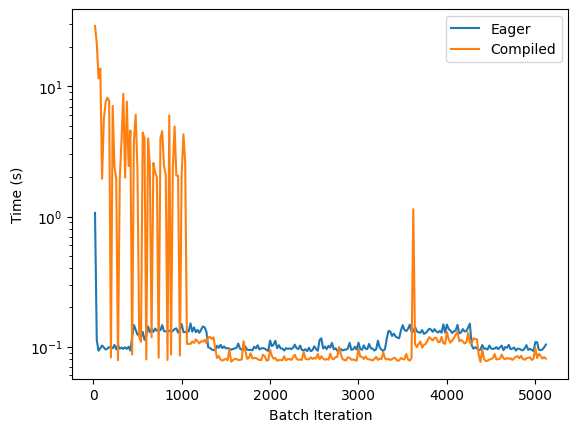

In [ ]:
x_vals = np.arange(1, len(eager_train_times) + 1) * track_interval
plt.plot(x_vals, eager_train_times, label="Eager")
plt.plot(x_vals, compiled_train_times, label="Compiled")
plt.yscale('log', base= 10)
plt.ylabel('Time (s)')
plt.xlabel('Batch Iteration')
plt.legend()
plt.show()

Looking at the graph, there is a significant difference in the time taken for the compiled and uncompiled versions of the model for the starting many steps. After that the time taken by the compiled model stabilises below the uncompiled model. This is because the compilation is done JIT when the model is first run and the optimized kernels are generated after a few passes.

### Tracking Inference Time

In [ ]:
model = dc.models.DMPNNModel()
model_compiled = dc.models.DMPNNModel()
model_compiled.compile(mode='reduce-overhead')

iters = 100

eager_predict_times = []
compiled_predict_times = []

for i in range(iters):
    for X, y, w, ids in test_dataset.iterbatches(64, pad_batches=True):
        with torch.no_grad():
            _, eager_time = time_torch_function(lambda: model.predict_on_batch(X))
            _, compiled_time = time_torch_function(lambda: model_compiled.predict_on_batch(X))

        eager_predict_times.append(eager_time)
        compiled_predict_times.append(compiled_time)

In [ ]:
print(f"Eager Times (first 15): {[f'{t:.3f}' for t in eager_predict_times[:15]]}")
print(f"Compiled Times (first 15): {[f'{t:.3f}' for t in compiled_predict_times[:15]]}")
print(f"Total Eager Time: {sum(eager_predict_times)}")
print(f"Total Compiled Time: {sum(compiled_predict_times)}")
print(f"Eager Median: {np.median(eager_predict_times)}")
print(f"Compiled Median: {np.median(compiled_predict_times)}")
print(f"Median Speedup: {((np.median(eager_predict_times) / np.median(compiled_predict_times)) - 1) * 100:.2f}%")

Eager Times (first 15): ['0.170', '0.173', '0.161', '0.160', '0.160', '0.165', '0.158', '0.159', '0.164', '0.161', '0.162', '0.154', '0.159', '0.161', '0.162']
Compiled Times (first 15): ['47.617', '1.168', '26.927', '0.127', '0.134', '0.138', '0.130', '0.130', '0.133', '0.125', '0.130', '0.132', '0.139', '0.128', '0.133']
Total Eager Time: 35.297711242675796
Total Compiled Time: 104.20891365814221
Eager Median: 0.1617226104736328
Compiled Median: 0.1332385482788086
Median Speedup: 21.38%


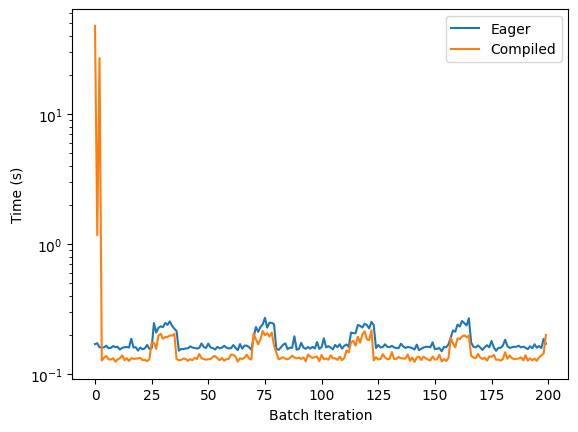

In [ ]:
plt.plot(eager_predict_times, label= "Eager")
plt.plot(compiled_predict_times, label= "Compiled")
plt.ylabel('Time (s)')
plt.xlabel('Batch Iteration')
plt.yscale('log', base= 10)
plt.legend()

As with the results we got training, the first few runs for inference also takes significantly more time due to the same reason as mentioned before.

# Congratulations! Time to join the Community!
Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:


## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.


## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!